<a href="https://colab.research.google.com/github/ajobi-uhc/hackathon-deepfakes/blob/main/latest_vh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'automathon-deepfake:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F77151%2F8401844%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240430%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240430T195037Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2f1af147451b61b9b37c274c0838d06d4c37cd281c5fa932291056fddf077c8fa77d3518e94bb97ad48aed973721d1c4fae5dae770addcfe382a284dccc6617038998dbdb970ced483d1211740cdd97b00437d32ab487747da390dc816925e5cda1708eec85ff3549d435b9da2590d13c3554a428dc26d9ab732ef373ca2c6657760eed8d98395ec796a37b42924f44cf6a135ecce303af6e41f497ece2def08abdf7e704190288ba3ed15f62a58156e593f3b65559f326c584d8884d30a865dd01ca1c8dff2726778adab2b12fd7076663d1708d70e1f5e1cb9e9fdd921db0d4adf99b3763c6398b5c6ad71261d33f8f1b1c0bf5e24f051cf3e5ddb91b2e2fc'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)

    if os.path.exists(destination_path) and len(os.listdir(destination_path)) > 0:
        print(f"Data already downloaded and extracted at {destination_path}, skipping download.")
        continue

    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3919757882 bytes downloaded
Downloaded and uncompressed: automathon-deepfake
Data source import complete.


In [3]:
!pip install av

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 49.4 MB/s eta 0:00:00


In [4]:
import torch
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_tensor, normalize
from torchvision.io import read_video
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import os
import glob
import numpy as np
from tqdm import tqdm
import json
from PIL import Image
from torchvision.utils import save_image
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
import torchvision.transforms.functional as F

In [39]:
DATASET_VIDEO_PATH = "/kaggle/input/automathon-deepfake/dataset/experimental_dataset"
DATASET_METADATA_PATH = "/kaggle/input/automathon-deepfake/dataset/experimental_dataset/metadata.json"
FRAME_SAVE_PATH = "/kaggle/working/frames"
FRAME_RATE = 1  # Frame rate to sample (e.g., 1 frame per second)

# Make sure the frame save directory exists
os.makedirs(FRAME_SAVE_PATH, exist_ok=True)

# Load video metadata
df_labels = pd.read_json(DATASET_METADATA_PATH, orient='index')
df_labels.reset_index(inplace=True)
df_labels.columns = ['Filename', 'Label']
df_labels['label_value'] = np.where(df_labels['Label'] == 'real', 1, 0)

In [42]:
class VideoDataset(Dataset):
    def __init__(self, dataframe, root_dir, sequence_length=10, transform=None):
        """
        Args:
            dataframe (DataFrame): DataFrame containing video filenames and labels.
            root_dir (str): Directory path where video files are stored.
            sequence_length (int): Number of frames to extract from each video.
            transform (callable, optional): Optional transform to be applied on a frame.
        """
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.sequence_length = sequence_length
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        video_filename = self.dataframe.iloc[idx]['Filename']
        video_path = os.path.join(self.root_dir, video_filename)
        label = self.dataframe.iloc[idx]['label_value']
        # Read video and extract frames
        frames, _, _ = read_video(video_path, pts_unit='sec', start_pts=0, end_pts=10, output_format='TCHW')
        total_frames = len(frames)
        frame_indices = torch.linspace(0, total_frames - 1, steps=self.sequence_length).long()
        selected_frames = frames[frame_indices]

        processed_frames = []
        for frame in selected_frames:
            if self.transform:
                frame = self.transform(frame)
            processed_frames.append(frame)

        frames_tensor = torch.stack(processed_frames)
        return frames_tensor, label

# Example of setting up the dataset and dataloader with transformations
transform = transforms.Compose([
    transforms.ToPILImage(),  # Necessary to convert raw video frame to PIL Image for some transformations
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),  # Convert the PIL Image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the tensor
])

dataset = VideoDataset(df_labels, DATASET_VIDEO_PATH, transform=transform)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

In [8]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [9]:
import timm
model = timm.create_model('vit_large_patch14_clip_224', pretrained=True)

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

In [49]:
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

model.head = nn.Identity()

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Freeze all the parameters in the model to prevent them from being updated during training
for param in model.parameters():
    param.requires_grad = False

# Define your classifier that will take the output features from the transformer
output_dims_of_CLIP = 1024  # This should match the output features of the last layer before the head
classifier = nn.Linear(in_features=output_dims_of_CLIP, out_features=1).to(device)
criterion = nn.BCEWithLogitsLoss()
initial_lr = 1e-4
optimizer = torch.optim.Adam(classifier.parameters(), lr=initial_lr)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
import torch
from tqdm import tqdm

num_epochs = 10  # Example epoch count
losses = []  # List to store all losses for visualization or further analysis

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    total_loss = 0.0
    num_batches = 0

    # Wrap the loader with tqdm for a progress bar
    progress_bar = tqdm(enumerate(loader), total=len(loader), desc="Training", leave=False)

    for batch_idx, (videos, labels) in progress_bar:
        videos = videos.to(device)  # [batch_size, seq_length, channels, height, width]
        labels = labels.to(device).float().unsqueeze(1)  # [batch_size, seq_length, 1]
        labels = labels.repeat(1, videos.size(1)).unsqueeze(-1)  # [batch_size, seq_length, 1]

        optimizer.zero_grad()
        video_loss = 0.0  # Accumulate loss for the batch

        for i in range(videos.size(1)):  # Process each frame in the sequence
            frames = videos[:, i, :, :, :]
            frame_features = model(frames)
            logits = classifier(frame_features).view(-1, 1)
            frame_labels = labels[:, i]
            loss = criterion(logits, frame_labels)
            video_loss += loss

        # Average the loss over the number of frames, then backpropagate
        video_loss /= videos.size(1)
        video_loss.backward()
        optimizer.step()

        # Record and print the average loss
        current_loss = video_loss.item()
        total_loss += current_loss
        losses.append(current_loss)

        # Update tqdm postfix to display the loss at the current batch
        progress_bar.set_postfix(loss=f"{current_loss:.4f}")

    average_loss = total_loss / len(loader)
    print(f"Epoch {epoch+1} Completed. Average Loss: {average_loss:.4f}\n")

Epoch 1/10


Training:   4%|▍         | 2/51 [00:14<03:51,  4.73s/it, loss=0.9037]

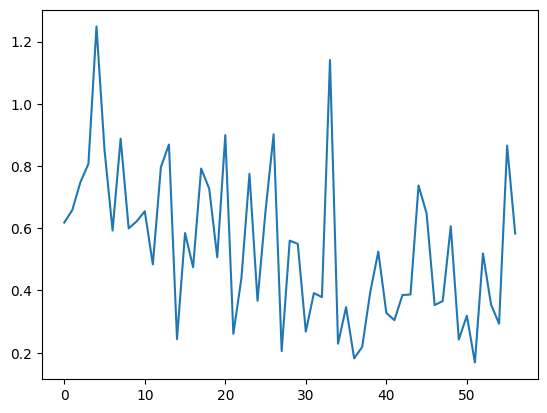

In [46]:
import matplotlib.pyplot as plt
plt.plot(losses)